# 04_05: Weather charts

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

We're going to conclude our practice with NumPy by making a quick but very impressive weather visualization that showcases the power and flexibility of NumPy and matplotlib.

Our visualization is inspired by the NY Times weather chart shown here, and it will present daily minima and maxima (the purple band), in the context of their normal range (dark grey) and of the historical records (light grey).

By the way, let me show you how to add images to a Jupyter notebook: if I double click on the cell containing the NY Times visualization, we see that it's just a Markdown cell with a small chunk of HTML, which in this case refers to a file in the current directory; but we could also use a full URL.

I shift-click inside this cell, and it goes back to showing the image.

<img src="nytimes.png">

Let's make our plot then. We will again use Pasadena as an example, but you will be able to do your own city if it's represented in the NOAA datasets. Remember, we want to show records... which means that we need all the data we can get for a city. The `getweather` module (which we import) lets us query for one year of data at a time, so we'll call it repeatedly, and collect the results with a list comprehension.

Once we have that, we can stack up the one-dimensional arrays so they become the rows of a two-dimensional array, using `np.vstack`.

In [2]:
import getweather

In [4]:
allyears = np.vstack([getweather.getyear('PASADENA', ['TMIN','TMAX'], year)
                      for year in range(1910, 2024)])

In [12]:
allyears['TMIN'].shape

(114, 365)

In [11]:
allyears['TMIN']

array([[ 2.2,  1.1, -0.6, ...,  1.7,  0.6,  1.1],
       [-0.6,  0.6,  1.1, ...,  0. , -1.7, -1.7],
       [ 3.3,  2.2,  0. , ..., -0.6,  0.6,  2.2],
       ...,
       [ 7.2,  7.2,  8.3, ...,  5.6,  8.9,  6.7],
       [ 6.7,  4.4,  4.4, ..., 11.7, 12.8, 12.8],
       [ 8.9,  6.7,  8.3, ..., 11.1, 11.1,  8.9]])

The result can be visualized with `matshow`. We add a colorbar to provide a reference to the mapping of values to color, and we can specify the `extent` to get more informative labels on the axes.

We see some missing data (the white patches), and we see that the middle of the year is warmer. We can also observe that winter and summer minima are getting warmer toward the end of the century.

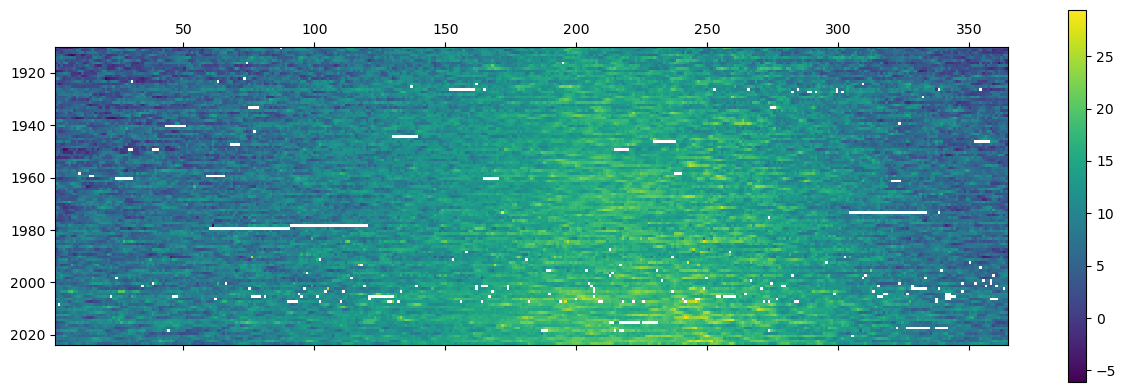

In [9]:
pp.matshow(allyears['TMIN'], extent=[1, 365, 2024, 1910])
pp.colorbar()

For simplicity, we will forgo filling nans, and use nan-robust functions. We want record temperatures for every day of the year. This means that we can use `np.nanmin` on the TMIN data, and specify `axis=0`, so that the minimum will be taken across each row of 114 years.

We do the same for TMAX, using `np.nanmax`.

In [15]:
tmin_record = np.nanmin(allyears['TMIN'], axis=0)
tmax_record = np.nanmax(allyears['TMAX'], axis=0)

Let's see the records!

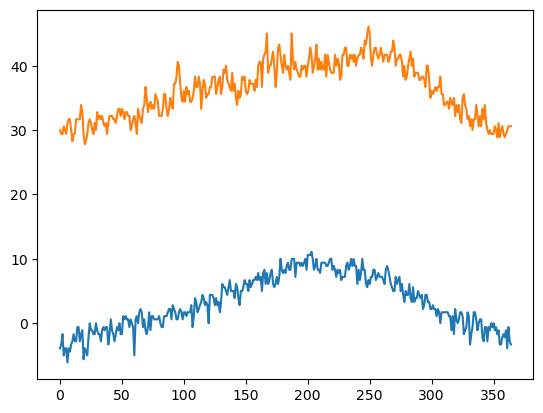

In [16]:
pp.plot(tmin_record)
pp.plot(tmax_record)

Now for the normals. In the NY Times visualization, the normal temperature range for each day of the year is defined as the average of the low and high from 1981 to 2010. So we build another stacked array, with this reduced range.

In [17]:
normal = np.vstack([getweather.getyear('PASADENA', ['TMIN','TMAX'], year)
                    for year in range(1981, 2011)])

Again, we take means (so `np.nanmean`) across rows (so `axis=0`). The same for tmax.

In [18]:
tmin_normal = np.nanmean(normal['TMIN'], axis=0)
tmax_normal = np.nanmean(normal['TMAX'], axis=0)

Let's have a look.

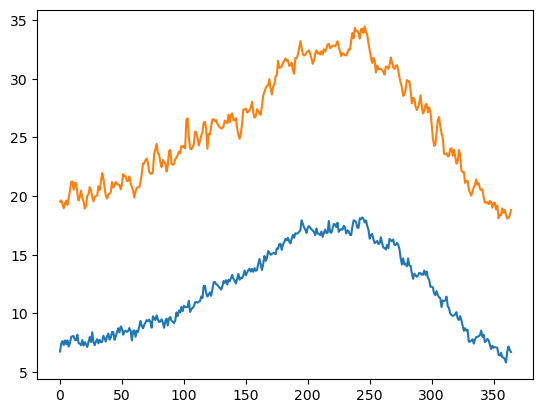

In [19]:
pp.plot(tmin_normal)
pp.plot(tmax_normal)

We're ready to get the plot together! We'll do Pasadena in 2020.

To plot a band we use matplotlib's fill_between, which needs x-axis coordinates, and the lower and upper lines that delimit the band. For x-axis coordinate I will use the day of the year, from 1 to 365.

The colors are my best approximation of the NY Times graphic.

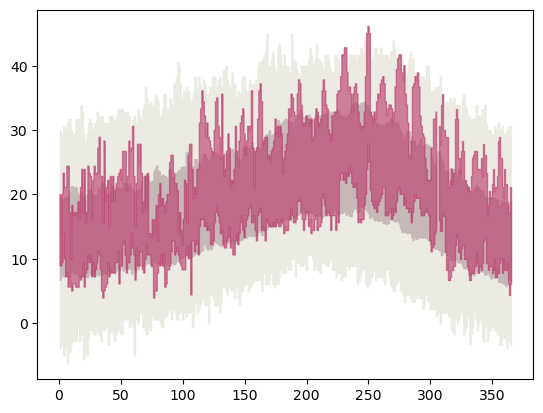

In [46]:
station, year = 'PASADENA', 2020
thisyear = getweather.getyear(station, ['TMIN', 'TMAX'], year)

days = np.arange(1, 366)
pp.fill_between(days, tmin_record, tmax_record, color=(0.92,0.92,0.89), step='mid') # step='mid' makes blocky regions 
pp.fill_between(days, tmin_normal, tmax_normal, color=(0.78,0.72,0.72), step='mid')
pp.fill_between(days, thisyear['TMIN'], thisyear['TMAX'], color=(0.73,0.21,0.41), alpha=0.6, step='mid'); # alpha sets transparency

We also want to show the average temperature for the year in the title. We will compute it as the average of the mean minimum and mean maximum temperatures.

To build a string for the title, I use the very convenient _formatted string literal_ introduced in Python 3.6. If we start the string with an "f" before the quotes, we can include variable names in braces, which will be replaced by their values. We can also specify formatting instructions as we would using the string `format` interface. For instance, one decimal digit for the average temperature.

This is the _best_ way to build up strings that include values!

In [43]:
avg = 0.5 * (np.nanmean(thisyear['TMIN']) + np.nanmean(thisyear['TMAX']))
avg

20.268080310100856

In [63]:
f'{station}, {year}: average temperature = {avg:.2f} °C'

'PASADENA, 2020: average temperature = 20.27 °C'

OK, let me put everything together in a function.

In [62]:
def nyplot(station, year):
    pp.figure(figsize=(12, 3.5))  # a better aspect ratio for the figure
     
    allyears = np.vstack([getweather.getyear(station, ['TMIN','TMAX'], year)
                          for year in range(1910, 2020)])
    
    normal = np.vstack([getweather.getyear(station, ['TMIN','TMAX'], year)
                        for year in range(1981, 2011)])

    thisyear = getweather.getyear(station, ['TMIN', 'TMAX'], year)
    
    tmin_record, tmax_record = np.nanmin(allyears['TMIN'], axis=0), np.nanmax(allyears['TMAX'], axis=0)
    tmin_normal, tmax_normal = np.nanmean(normal['TMIN'], axis=0), np.nanmean(normal['TMAX'], axis=0)

    days = np.arange(1, 366)
    pp.fill_between(days, tmin_record, tmax_record, color=(0.92,0.92,0.89), step='mid')
    pp.fill_between(days, tmin_normal, tmax_normal, color=(0.78,0.72,0.72), step='mid')
    pp.fill_between(days, thisyear['TMIN'], thisyear['TMAX'], color=(0.73,0.21,0.41), alpha=0.6, step='mid')

    pp.axis(xmin=1, xmax=365, ymin=-15, ymax=50)
    pp.xticks(range(15, 365, 30), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    pp.ylabel('temperature, °C')
    
    avg = 0.5*(np.nanmean(thisyear['TMIN']) + np.nanmean(thisyear['TMAX']))
    pp.title(f'{station}, {year}: average temperature = {avg:.2f} °C');               # later

Here's New York in 2020!

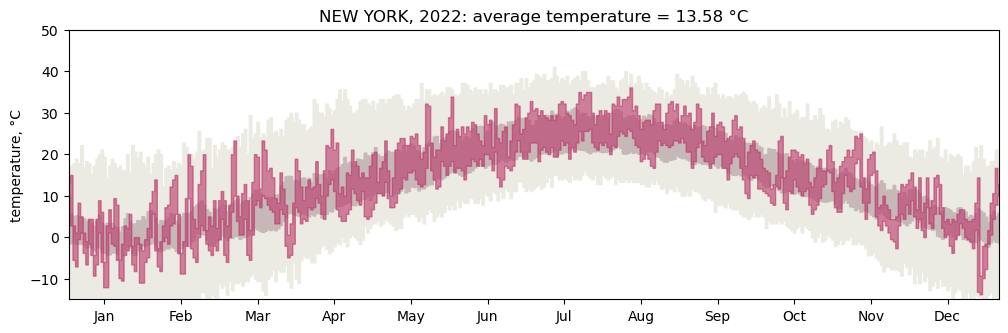

In [72]:
nyplot('NEW YORK', 2022)

NumPy is extremely powerful and flexible; you should learn about it in depth. Coupled with `matplotlib`, it offers a direct route to beautiful and informative visualizations.

You are now ready for your challenge!